In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats.mstats import winsorize

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
#pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

## for this project I'm using 2019 player information from fifa. I got this csv from kaggle, but the same dataset can be found on the thinkful postgres sql server

In [2]:
# import data
fifa19 = pd.read_csv('/Users/richardlafferty/Downloads/fifa19.csv')

In [3]:
# checking data info
fifa19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
Unnamed: 0                  18207 non-null int64
ID                          18207 non-null int64
Name                        18207 non-null object
Age                         18207 non-null int64
Photo                       18207 non-null object
Nationality                 18207 non-null object
Flag                        18207 non-null object
Overall                     18207 non-null int64
Potential                   18207 non-null int64
Club                        17966 non-null object
Club Logo                   18207 non-null object
Value                       18207 non-null object
Wage                        18207 non-null object
Special                     18207 non-null int64
Preferred Foot              18159 non-null object
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null fl

In [4]:
display(fifa19.head())

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## I am going to be looking to run a regression algorithm which will let me find with reasonable accuracy, the value of a player in regards to his salary. My goal is to see if I can optimize a fantasy draft.

In [5]:
fifa19.describe()

,Unnamed: 0,ID,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18147.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,9103.000000,214298.338606,25.122206,66.238699,71.307299,1597.809908,1.113222,2.947299,2.361308,19.546096,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,5256.052511,29965.244204,4.669943,6.908930,6.136496,272.586016,0.394031,0.660456,0.756164,15.947765,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,0.000000,16.000000,16.000000,46.000000,48.000000,731.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4551.500000,200315.500000,21.000000,62.000000,67.000000,1457.000000,1.000000,3.000000,2.000000,8.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,9103.000000,221759.000000,25.000000,66.000000,71.000000,1635.000000,1.000000,3.000000,2.000000,17.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,13654.500000,236529.500000,28.000000,71.000000,75.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,18206.000000,246620.000000,45.000000,94.000000,95.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [6]:
# I think some of these are inconsequential to us and I'll drop them now
fifa19 = fifa19.drop(['Photo', 'Flag', 'Club Logo', 'ID',
                      'Jersey Number', 'Real Face', 
                      'Contract Valid Until', 'Joined'], axis=1)

In [7]:
#list of numeric columns
cont_columns = list(fifa19.select_dtypes(exclude='object'))
#list of categorical columns
cat_columns = list(fifa19.select_dtypes('object'))
print(cont_columns)
print(cat_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
['Name', 'Nationality', 'Club', 'Value', 'Wage', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Release Clause']


In [8]:
fifa19.head()

,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [9]:
fifa19.columns

Index(['Unnamed: 0', 'Name', 'Age', 'Nationality', 'Overall', 'Potential',
       'Club', 'Value', 'Wage', 'Special', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST',
       'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Release Clause'],
   

In [10]:
#looking at null values
print((fifa19.isnull().sum().sort_values(ascending=False)))

Loaned From        16943
RWB                 2085
LM                  2085
CB                  2085
LCB                 2085
LB                  2085
RDM                 2085
CDM                 2085
LDM                 2085
LWB                 2085
RM                  2085
RCM                 2085
CM                  2085
LCM                 2085
RAM                 2085
RB                  2085
CAM                 2085
LAM                 2085
RW                  2085
RF                  2085
CF                  2085
LF                  2085
LW                  2085
RS                  2085
ST                  2085
LS                  2085
RCB                 2085
Release Clause      1564
Club                 241
Position              60
                   ...  
Interceptions         48
SprintSpeed           48
Volleys               48
ShortPassing          48
HeadingAccuracy       48
Finishing             48
Crossing              48
Aggression            48
LongPassing           48


In [11]:
#dropping loaned from because it's missing over 90% of its data
fifa19 = fifa19.drop(['Loaned From'], axis=1)

In [12]:
fifa19.loc[fifa19.CDM.isnull()]
#so there are some pretty important players missing these values. 
#I would hate to lose that data. I'll have to interpolate the nulls

,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
3,3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
9,9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,€68M,€94K,1331,...,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,€144.5M
18,18,M. ter Stegen,26,Germany,89,92,FC Barcelona,€58M,€240K,1328,...,69.0,25.0,13.0,10.0,87.0,85.0,88.0,85.0,90.0,€123.3M
19,19,T. Courtois,26,Belgium,89,90,Real Madrid,€53.5M,€240K,1311,...,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0,€113.7M
22,22,M. Neuer,32,Germany,89,89,FC Bayern München,€38M,€130K,1473,...,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0,€62.7M
37,37,H. Lloris,31,France,88,88,Tottenham Hotspur,€36M,€150K,1335,...,65.0,29.0,10.0,18.0,88.0,84.0,68.0,83.0,92.0,€66.6M
40,40,S. Handanovič,33,Slovenia,88,88,Inter,€30M,€110K,1262,...,69.0,25.0,10.0,13.0,87.0,86.0,69.0,89.0,89.0,€51M
41,41,G. Buffon,40,Italy,88,88,Paris Saint-Germain,€4M,€77K,1334,...,70.0,13.0,11.0,11.0,88.0,87.0,74.0,90.0,83.0,€7.4M
46,46,K. Navas,31,Costa Rica,87,87,Real Madrid,€30.5M,€195K,1345,...,67.0,28.0,14.0,14.0,90.0,81.0,75.0,82.0,90.0,€62.5M
57,57,Ederson,24,Brazil,86,90,Manchester City,€41.5M,€125K,1463,...,70.0,28.0,15.0,8.0,85.0,80.0,91.0,82.0,87.0,€79.9M


In [13]:
#I will fill these null values using interpolation
fifa19 = fifa19.interpolate()

In [14]:
fifa19.CDM.value_counts()

62+2    660
60+2    620
61+2    620
64+2    592
59+2    592
63+2    573
58+2    565
65+2    539
57+2    529
66+2    524
56+2    520
54+2    505
55+2    479
53+2    471
51+2    468
49+2    448
52+2    444
50+2    438
68+2    428
48+2    427
67+2    426
47+2    396
69+2    362
46+2    359
44+2    339
45+2    325
70+2    302
43+2    282
71+2    271
42+2    239
       ... 
82+3      8
62+3      7
69+3      6
57+3      6
52+3      6
63+3      6
66+3      6
53+3      6
51+3      5
79+3      5
81+2      5
64+3      4
65+3      4
54+3      4
29+2      4
67+3      4
68+3      3
49+3      2
45+3      2
84+3      2
50+3      2
57+4      1
28+2      1
68+5      1
86+3      1
83+2      1
82+2      1
46+3      1
87+3      1
85+3      1
Name: CDM, Length: 99, dtype: int64

In [15]:
#all these columns have a + value added, 
#which according to my soccer friends is not important 
cols = ["LS", "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM", "LCM",
        "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB", "CB", "RCB", "RB"]
for col in cols:
    fifa19[col] = fifa19[col].str[:-2]
    fifa19[col] = fifa19[col].astype(float)

In [16]:
print(fifa19['Height'].head())
print(fifa19['Height'].isnull().sum())
fifa19['Height'].dropna(inplace=True)

0     5'7
1     6'2
2     5'9
3     6'4
4    5'11
Name: Height, dtype: object
48


In [17]:
#write a function that splits height into feet and inches and returns just inches as a float
def parse_height(ht):
    height = ht.split("'")
    #print(height) #used this to see my output after splitting
    feet = float(height[0])
    inches = float(height[1])
    return (12*feet) + inches
fifa19['Height'] = fifa19['Height'].apply(lambda x: parse_height(x))


In [18]:
#Correct Weight
fifa19['Weight']=fifa19['Weight'].str[:-3]
fifa19['Weight']=fifa19['Weight'].astype(float)

print(fifa19.Height.head())
print(fifa19.Weight.head())


0    67.0
1    74.0
2    69.0
3    76.0
4    71.0
Name: Height, dtype: float64
0    159.0
1    183.0
2    150.0
3    168.0
4    154.0
Name: Weight, dtype: float64


In [19]:
display(fifa19.head(200))

,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
5,5,E. Hazard,27,Belgium,91,91,Chelsea,€93M,€340K,2142,...,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,€172.1M
6,6,L. Modrić,32,Croatia,91,91,Real Madrid,€67M,€420K,2280,...,84.0,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0,€137.4M
7,7,L. Suárez,31,Uruguay,91,91,FC Barcelona,€80M,€455K,2346,...,85.0,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0,€164M
8,8,Sergio Ramos,32,Spain,91,91,Real Madrid,€51M,€380K,2201,...,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0,€104.6M
9,9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,€68M,€94K,1331,...,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,€144.5M


In [20]:
#changing all currency columns into float columns to help analyze

curs=["Release Clause", "Value", "Wage"]
for cur in curs:
    
    def curr_value(x):
        x = str(x).replace('€', '')
        if('M' in str(x)):
            x = str(x).replace('M', '')
            x = float(x) * 1000000
        elif('K' in str(x)):
            x = str(x).replace('K', '')
            x = float(x) * 1000
        return float(x)
    fifa19[cur] = fifa19[cur].apply(curr_value)

In [21]:
cont_columns = cont_columns + curs
cat_columns = ['Name', 'Nationality', 'Club', 'Preferred Foot',
               'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight',
               'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
               'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB',
               'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
               'International Reputation', 'Weak Foot', 'Skill Moves']

In [22]:
print(cont_columns)
print(cat_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause', 'Value', 'Wage']
['Name', 'Nationality', 'Club', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'International Reputation', 'Weak Foot', 'Skill Moves']


In [23]:
#looking at our target variable
fifa19['value_overall'] = fifa19['Overall'] / fifa19['Value']
print(fifa19['value_overall'].head())
print(fifa19['value_overall'].min())
print(fifa19['value_overall'].max())

0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
3    1.263889e-06
4    8.921569e-07
Name: value_overall, dtype: float64
7.763713080168777e-07
inf


In [24]:
#having an inf value will certainly mess up our model so I will try to take care of it now
fifa19.value_overall = fifa19.value_overall.replace(np.inf, np.nan)
print(fifa19.value_overall.max())
print(fifa19.value_overall.isnull().sum())
#if we only have 252 null values then I feel ok with just dropping those rows
print(fifa19.value_overall.head())



0.006
252
0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
3    1.263889e-06
4    8.921569e-07
Name: value_overall, dtype: float64


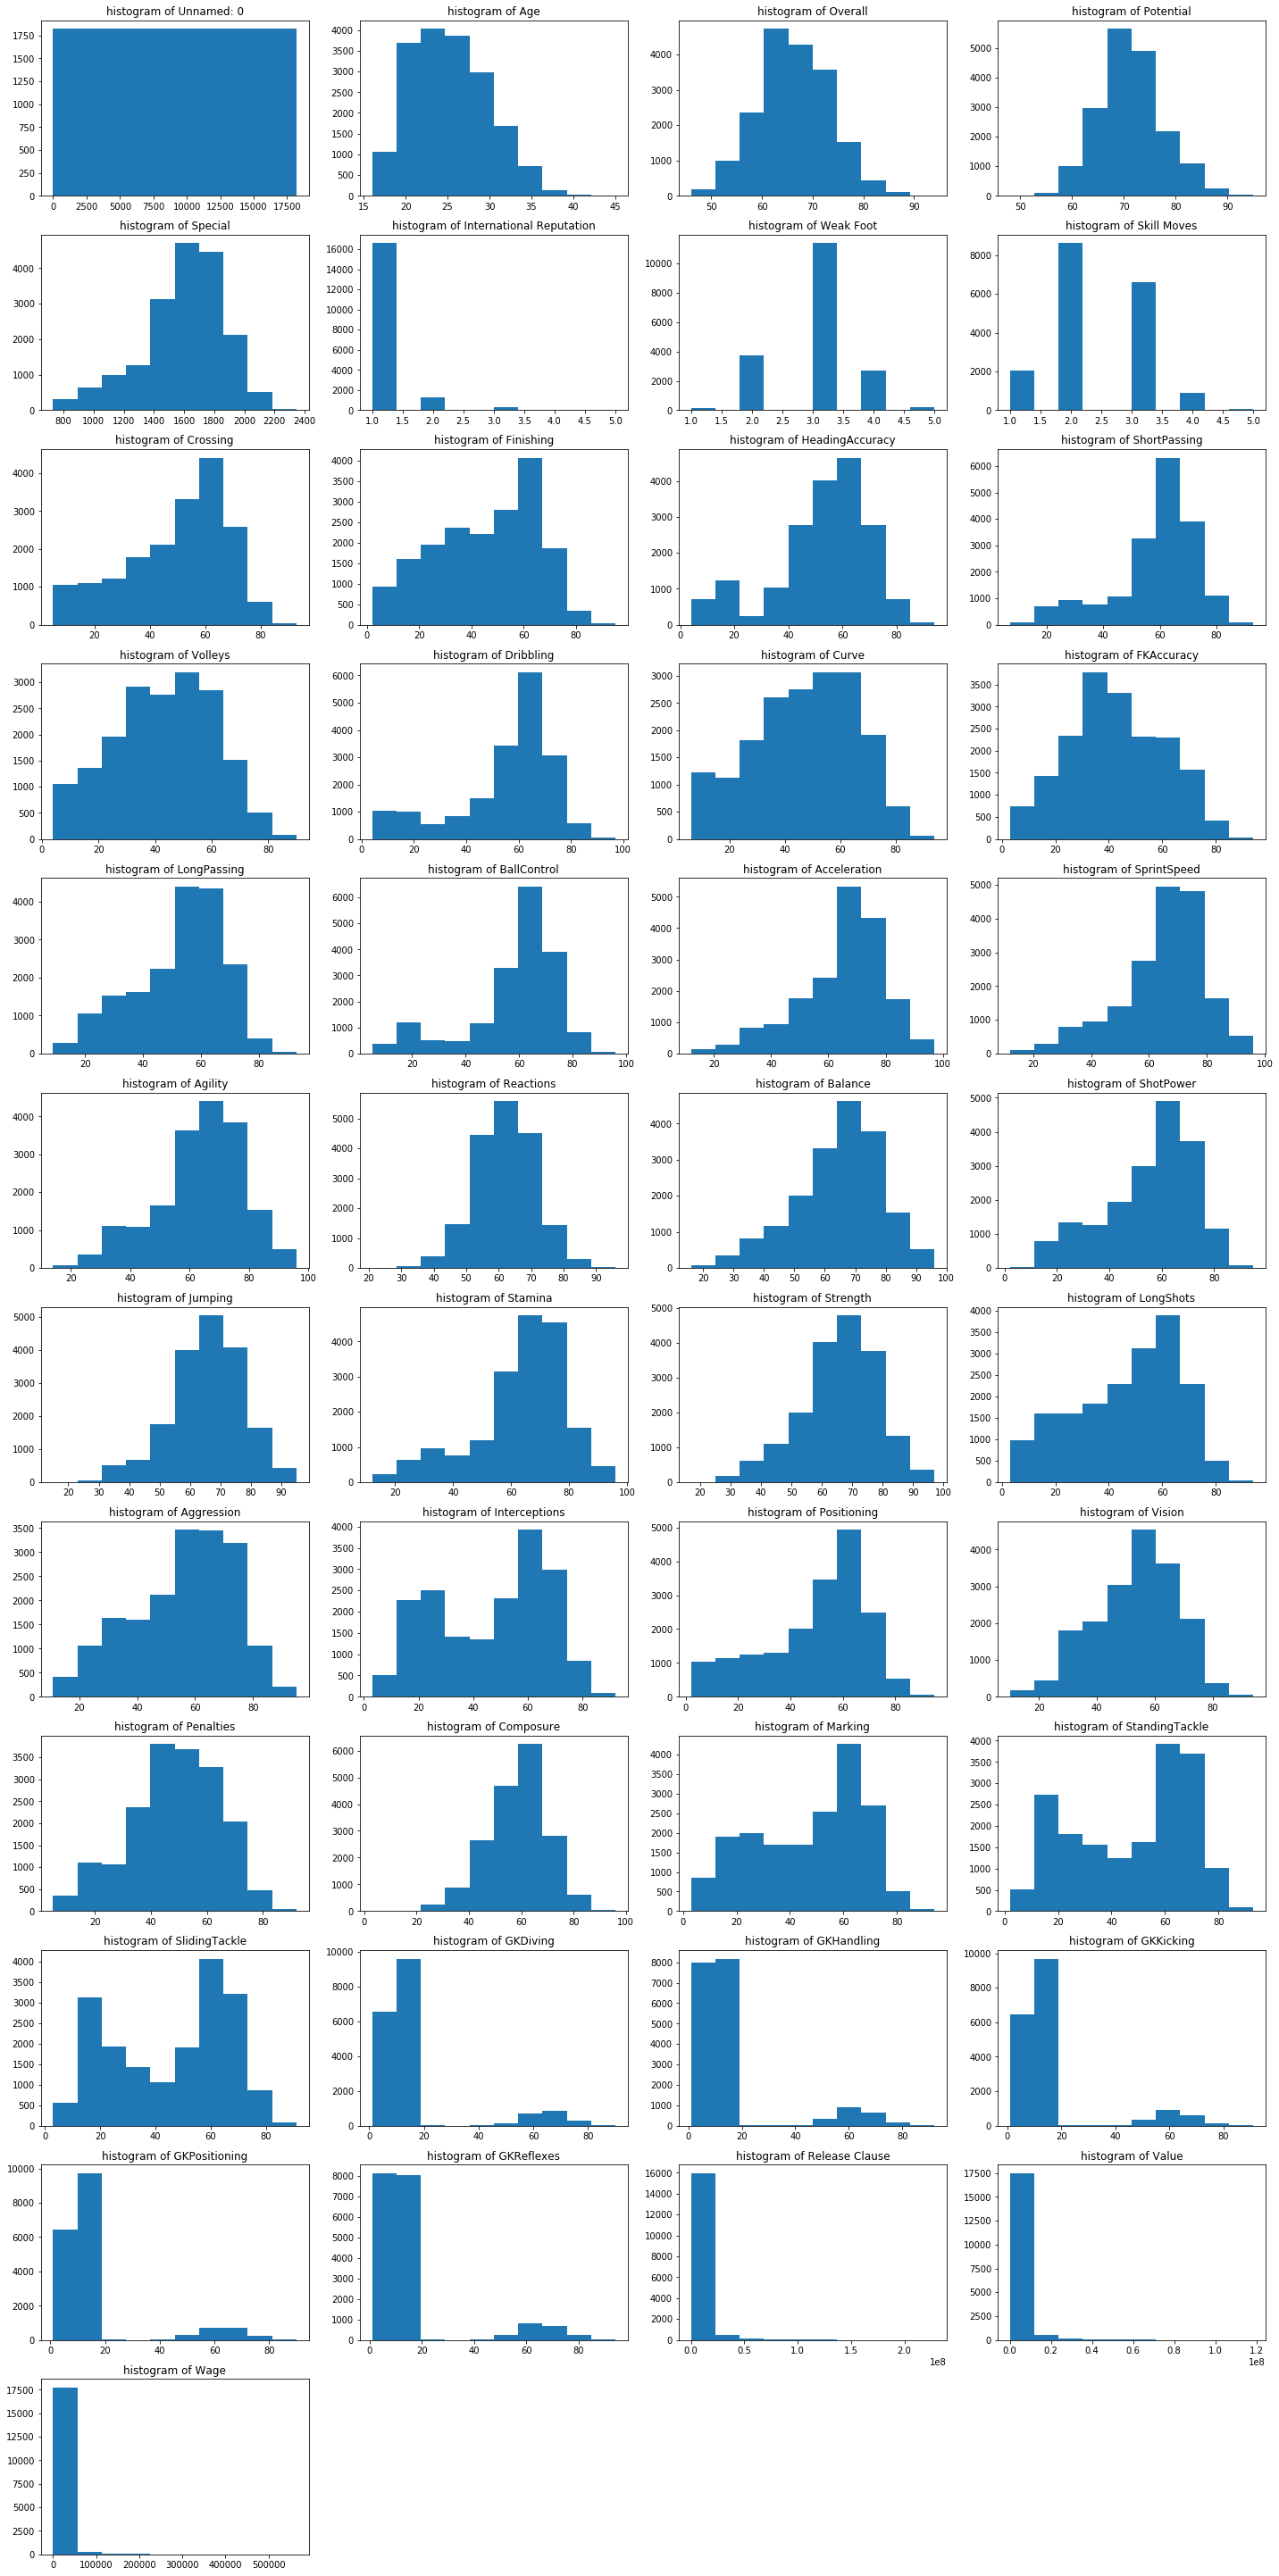

In [25]:
fig = plt.figure(figsize=(20,150))
for i, col in enumerate(cont_columns):
    
    plt.subplot(len(cont_columns), 4, i+1)
    plt.hist(fifa19[col])
    plt.title('histogram of {}'.format(col))
    plt.tight_layout()

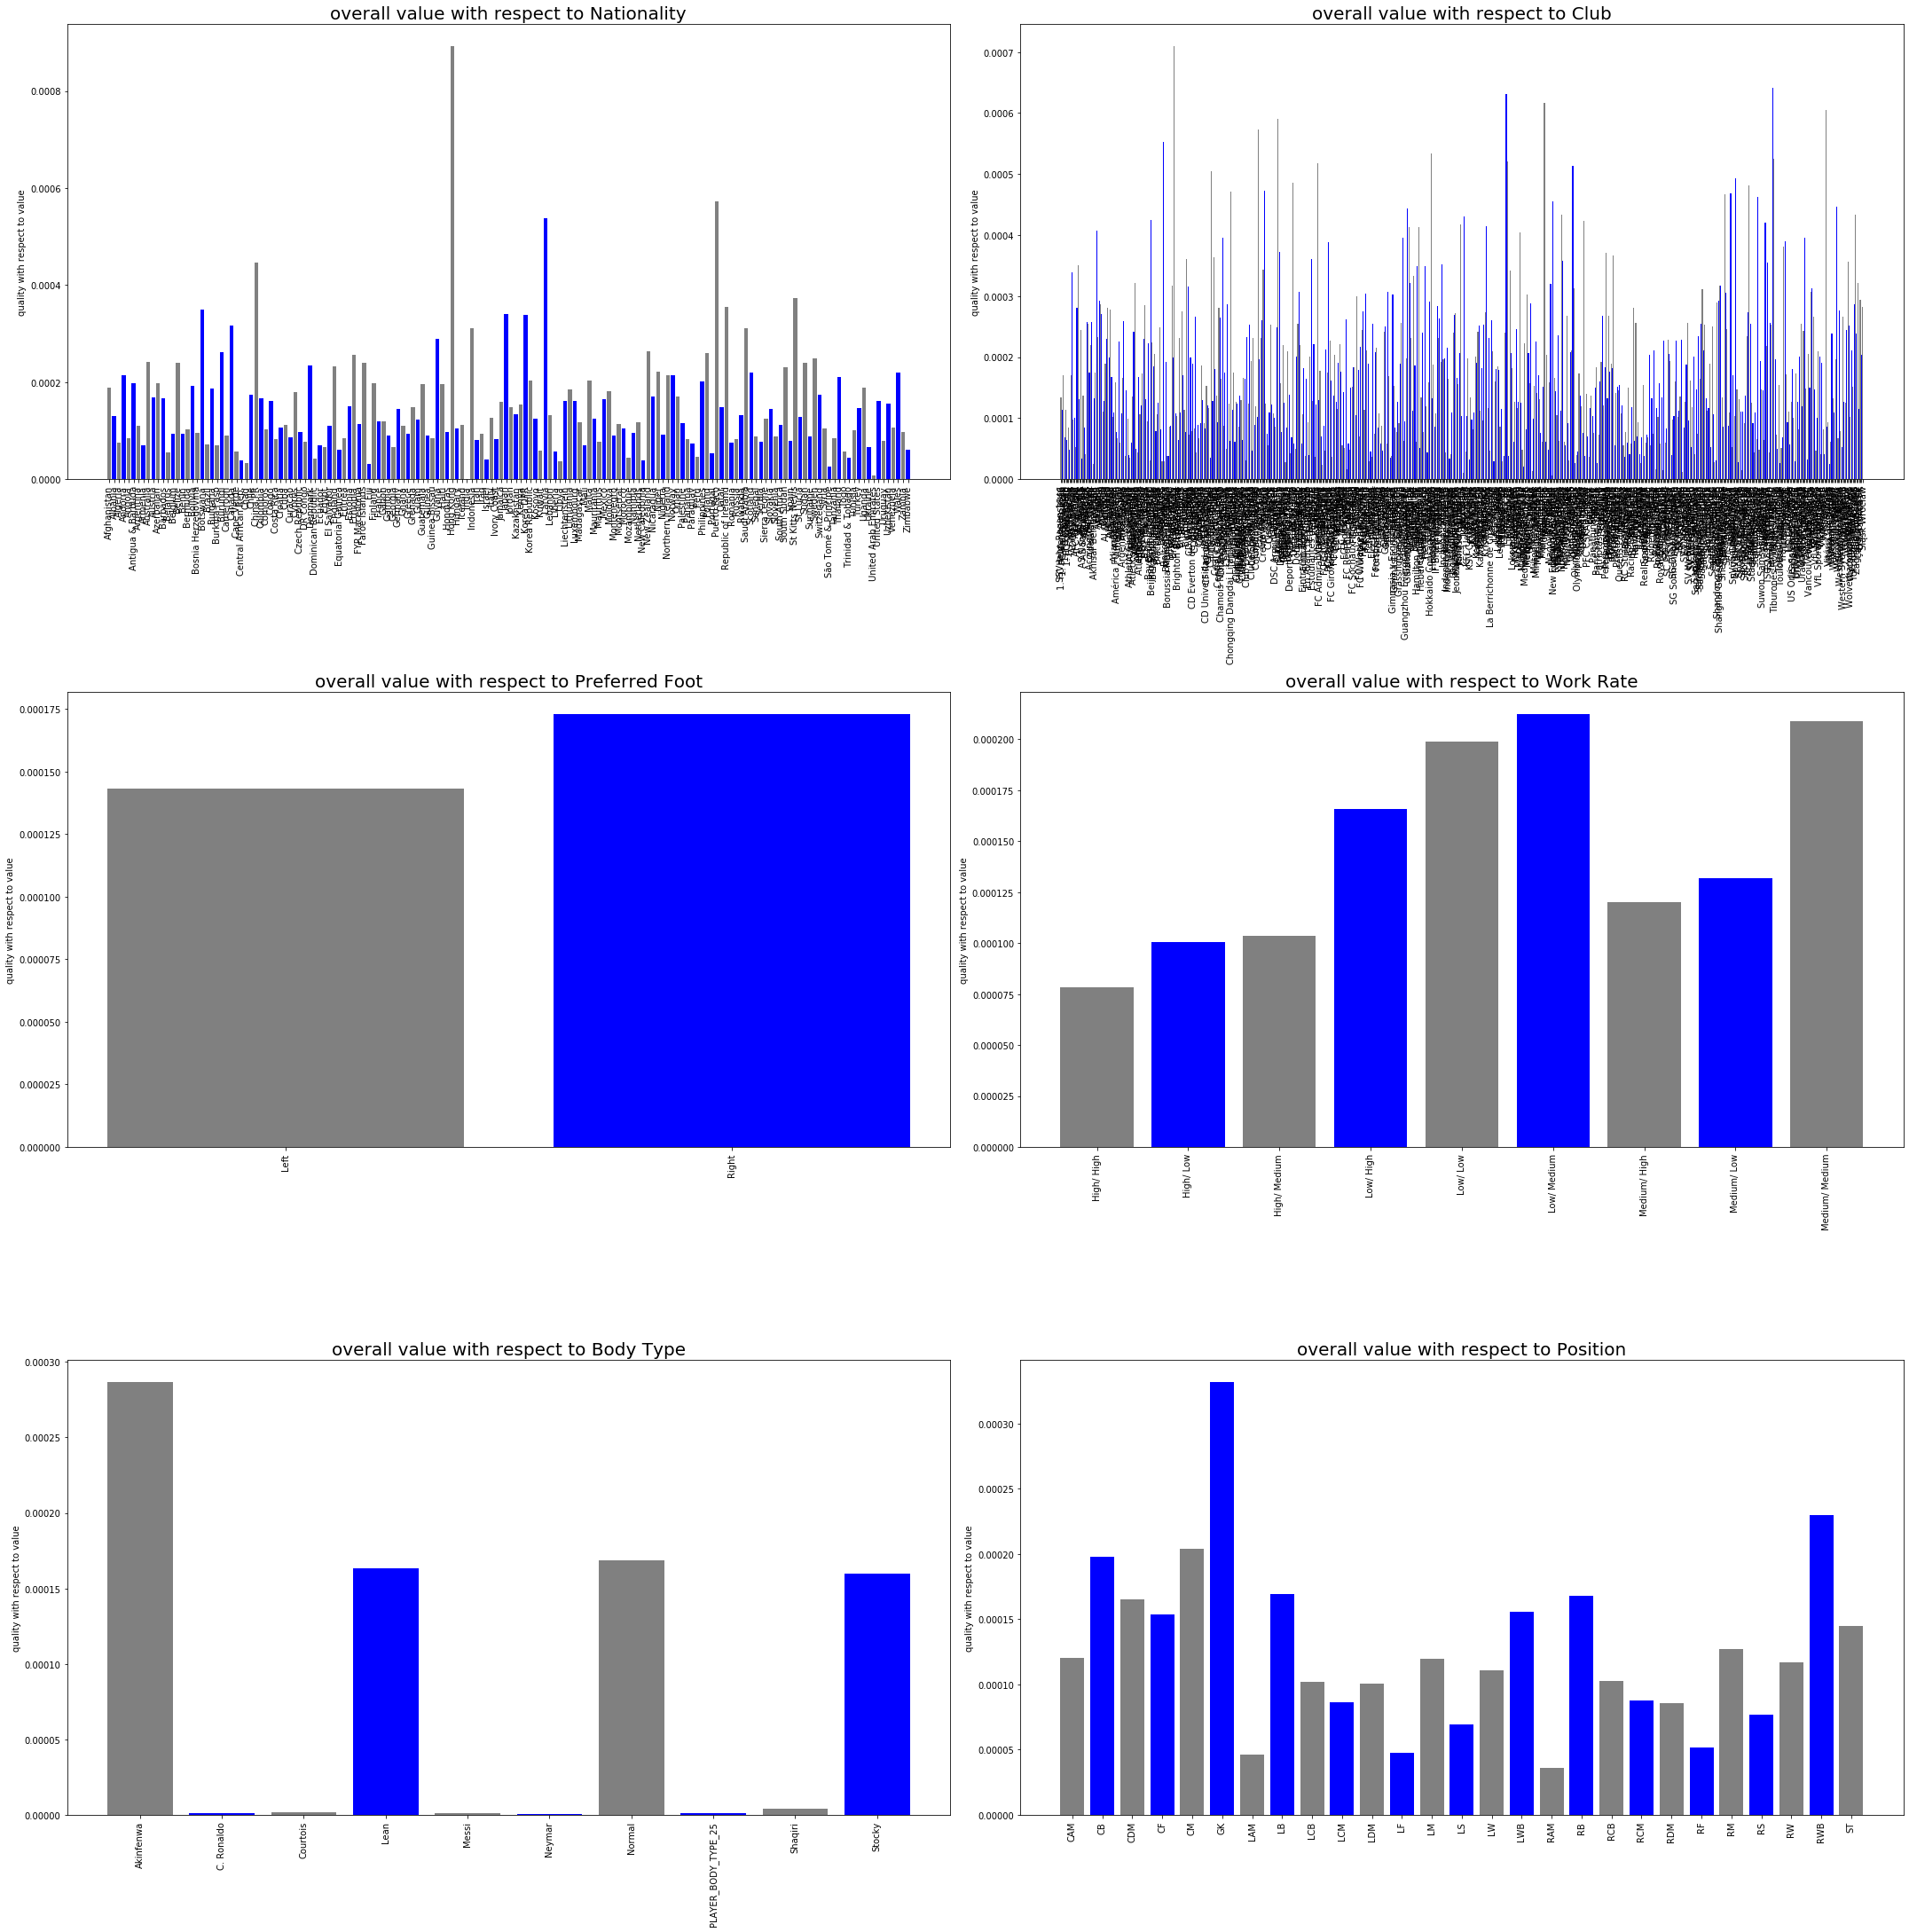

In [26]:
object_columns = ['Nationality',
                  'Club',
                  'Preferred Foot',
                  'Work Rate',
                  'Body Type',
                  'Position']

plt.figure(figsize=(30, 60))
for i, col in enumerate(object_columns):
    plt.subplot(len(object_columns), 2, i+1)
    plt.bar(fifa19.groupby(col)['value_overall'].mean(
    ).index, fifa19.groupby(col)['value_overall'].mean(), color=('grey', 'blue'))
    plt.ylabel('quality with respect to value')
    plt.xticks(rotation='vertical')
    plt.title('overall value with respect to {}'.format(col), fontsize=20)
    plt.tight_layout()
    #there's a lot of noise in the Nationality and Club

In [27]:
#I feel like there's too much noise in the nationality variable and Club variable

fifa19 = fifa19.drop(columns=['Nationality', 'Club'])

'''obj_df = fifa19.select_dtypes(include=['object']).copy()
#Encoding object columns
cols=obj_df.columns
for col in cols:
    print(col)
    fifa19[col].replace(np.NaN,'NotAv',inplace=True)
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    labelencoder_X = LabelEncoder()
    fifa19[col] = labelencoder_X.fit_transform(fifa19[col])'''

"obj_df = fifa19.select_dtypes(include=['object']).copy()\n#Encoding object columns\ncols=obj_df.columns\nfor col in cols:\n    print(col)\n    fifa19[col].replace(np.NaN,'NotAv',inplace=True)\n    from sklearn.preprocessing import LabelEncoder, OneHotEncoder\n    labelencoder_X = LabelEncoder()\n    fifa19[col] = labelencoder_X.fit_transform(fifa19[col])"

In [28]:
fifa19['value_overall'] = fifa19['Overall'] / fifa19['Value']
fifa19 = fifa19.replace([np.inf, -np.inf], np.nan)

print(fifa19.isnull().sum().sort_values(ascending=False))


LCB                2085
RB                 2085
CB                 2085
LB                 2085
RWB                2085
RDM                2085
CDM                2085
LDM                2085
LWB                2085
RM                 2085
RCM                2085
CM                 2085
LCM                2085
LM                 2085
RAM                2085
CAM                2085
LAM                2085
RW                 2085
RF                 2085
CF                 2085
LF                 2085
LW                 2085
RS                 2085
ST                 2085
LS                 2085
RCB                2085
Release Clause     1564
value_overall       252
Position             60
Work Rate            48
                   ... 
Overall               0
Age                   0
Name                  0
StandingTackle        0
Composure             0
Curve                 0
Agility               0
Dribbling             0
Volleys               0
ShortPassing          0
HeadingAccuracy 

In [29]:
fifa19.dropna(inplace=True)

## All null and inf values have been taken care of and now I can start dealing with outliers

In [30]:
print(len(fifa19))

14743


In [31]:
cont_columns = ['Unnamed: 0', 'Age', 'Overall',
                  'Potential', 'Special', 'Crossing',
                  'Finishing', 'HeadingAccuracy', 'ShortPassing',
                  'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
                  'LongPassing', 'BallControl', 'Acceleration',
                  'SprintSpeed', 'Agility', 'Reactions', 'Balance',
                  'ShotPower', 'Jumping', 'Stamina', 'Strength',
                  'LongShots', 'Aggression', 'Interceptions',
                  'Positioning', 'Vision', 'Penalties', 'Composure',
                  'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
                  'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
                  'Release Clause', 'Value', 'Wage', 'LS', 'Weight', 'RCM', 'RWB']
#cont_columns = fifa19.select_dtypes(exclude='object')
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                              len((np.where((fifa19[col] > max_val) |
                                                                                            (fifa19[col] < min_val))[0])), len((np.where((fifa19[col] > max_val) |
                                                                                                                                              (fifa19[col] < min_val))[0]))*100/17955))
   

Number of outliers and percentage of it in Unnamed: 0 : 0 and %0.0
Number of outliers and percentage of it in Age : 12 and %0.06683375104427736
Number of outliers and percentage of it in Overall : 140 and %0.7797270955165692
Number of outliers and percentage of it in Potential : 127 and %0.707323865218602
Number of outliers and percentage of it in Special : 18 and %0.10025062656641603
Number of outliers and percentage of it in Crossing : 4 and %0.02227791701475912
Number of outliers and percentage of it in Finishing : 0 and %0.0
Number of outliers and percentage of it in HeadingAccuracy : 47 and %0.26176552492341965
Number of outliers and percentage of it in ShortPassing : 327 and %1.821219715956558
Number of outliers and percentage of it in Volleys : 0 and %0.0
Number of outliers and percentage of it in Dribbling : 549 and %3.0576441102756893
Number of outliers and percentage of it in Curve : 0 and %0.0
Number of outliers and percentage of it in FKAccuracy : 0 and %0.0
Number of outli

In [32]:
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0])),len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0]))*100/17955))
    
    
    print('percent of outliers low')
    print(len(np.where(fifa19[col] < min_val)[0]) /17955)
    print('Percent of outliers high')
    print(len(np.where(fifa19[col] > max_val)[0]) /17955)
    print(90 * '-')

Number of outliers and percentage of it in Unnamed: 0 : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Age : 12 and %0.06683375104427736
percent of outliers low
0.0
Percent of outliers high
0.0006683375104427736
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Overall : 140 and %0.7797270955165692
percent of outliers low
0.002506265664160401
Percent of outliers high
0.005291005291005291
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Potential : 127 and %0.707323865218602
percent of outliers low
0.0010025062656641604
Percent of outliers high
0.00607073238652186
------------------------------------------------------------------------------------------
Number of outli

Number of outliers and percentage of it in GKKicking : 12 and %0.06683375104427736
percent of outliers low
0.0
Percent of outliers high
0.0006683375104427736
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in GKPositioning : 6 and %0.03341687552213868
percent of outliers low
0.0
Percent of outliers high
0.0003341687552213868
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in GKReflexes : 10 and %0.0556947925368978
percent of outliers low
0.0
Percent of outliers high
0.000556947925368978
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Release Clause : 2097 and %11.679197994987469
percent of outliers low
0.0
Percent of outliers high
0.11679197994987468
-----------------------------------------------------------------------------------------

In [33]:
#for loop for winsorizing outlier values
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    fifa19[col] = winsorize(fifa19[col], (len(np.where(fifa19[col] < min_val)[0]) / 17955,
                                          len(np.where(fifa19[col] > max_val)[
                                              0]) / 17955
                                          )
                            )

In [34]:
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0])),len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0]))*100/17955))
    
    
    print('percent of outliers low')
    print(len(np.where(fifa19[col] < min_val)[0]) /17955)
    print('Percent of outliers high')
    print(len(np.where(fifa19[col] > max_val)[0]) /17955)
    print(90 * '-')

Number of outliers and percentage of it in Unnamed: 0 : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Age : 12 and %0.06683375104427736
percent of outliers low
0.0
Percent of outliers high
0.0006683375104427736
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Overall : 140 and %0.7797270955165692
percent of outliers low
0.002506265664160401
Percent of outliers high
0.005291005291005291
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Potential : 127 and %0.707323865218602
percent of outliers low
0.0010025062656641604
Percent of outliers high
0.00607073238652186
------------------------------------------------------------------------------------------
Number of outli

Number of outliers and percentage of it in Value : 1997 and %11.12225006961849
percent of outliers low
0.0
Percent of outliers high
0.1112225006961849
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Wage : 1683 and %9.3734335839599
percent of outliers low
0.0
Percent of outliers high
0.093734335839599
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in LS : 17 and %0.09468114731272625
percent of outliers low
0.0001113895850737956
Percent of outliers high
0.000835421888053467
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Weight : 136 and %0.75744917850181
percent of outliers low
0.002172096908939014
Percent of outliers high
0.0054023948760790865
------------------------------------------------------------------------------------------


In [35]:
#I missed the Release Clause variable so just manually winsorizing
fifa19['Release Clause'] = winsorize(fifa19['Release Clause'], (0, .144))


In [36]:
#X and y assignments
X = fifa19.loc[:, fifa19.columns != 'Value']
X = X.drop(columns='Overall')
X = X.drop(columns='value_overall')
# get dummies for our X values
y = fifa19['value_overall']
print(fifa19['value_overall'].head())
print(fifa19['value_overall'].min())
print(fifa19['value_overall'].max())

0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
4    8.921569e-07
5    9.784946e-07
Name: value_overall, dtype: float64
7.763713080168777e-07
0.0057


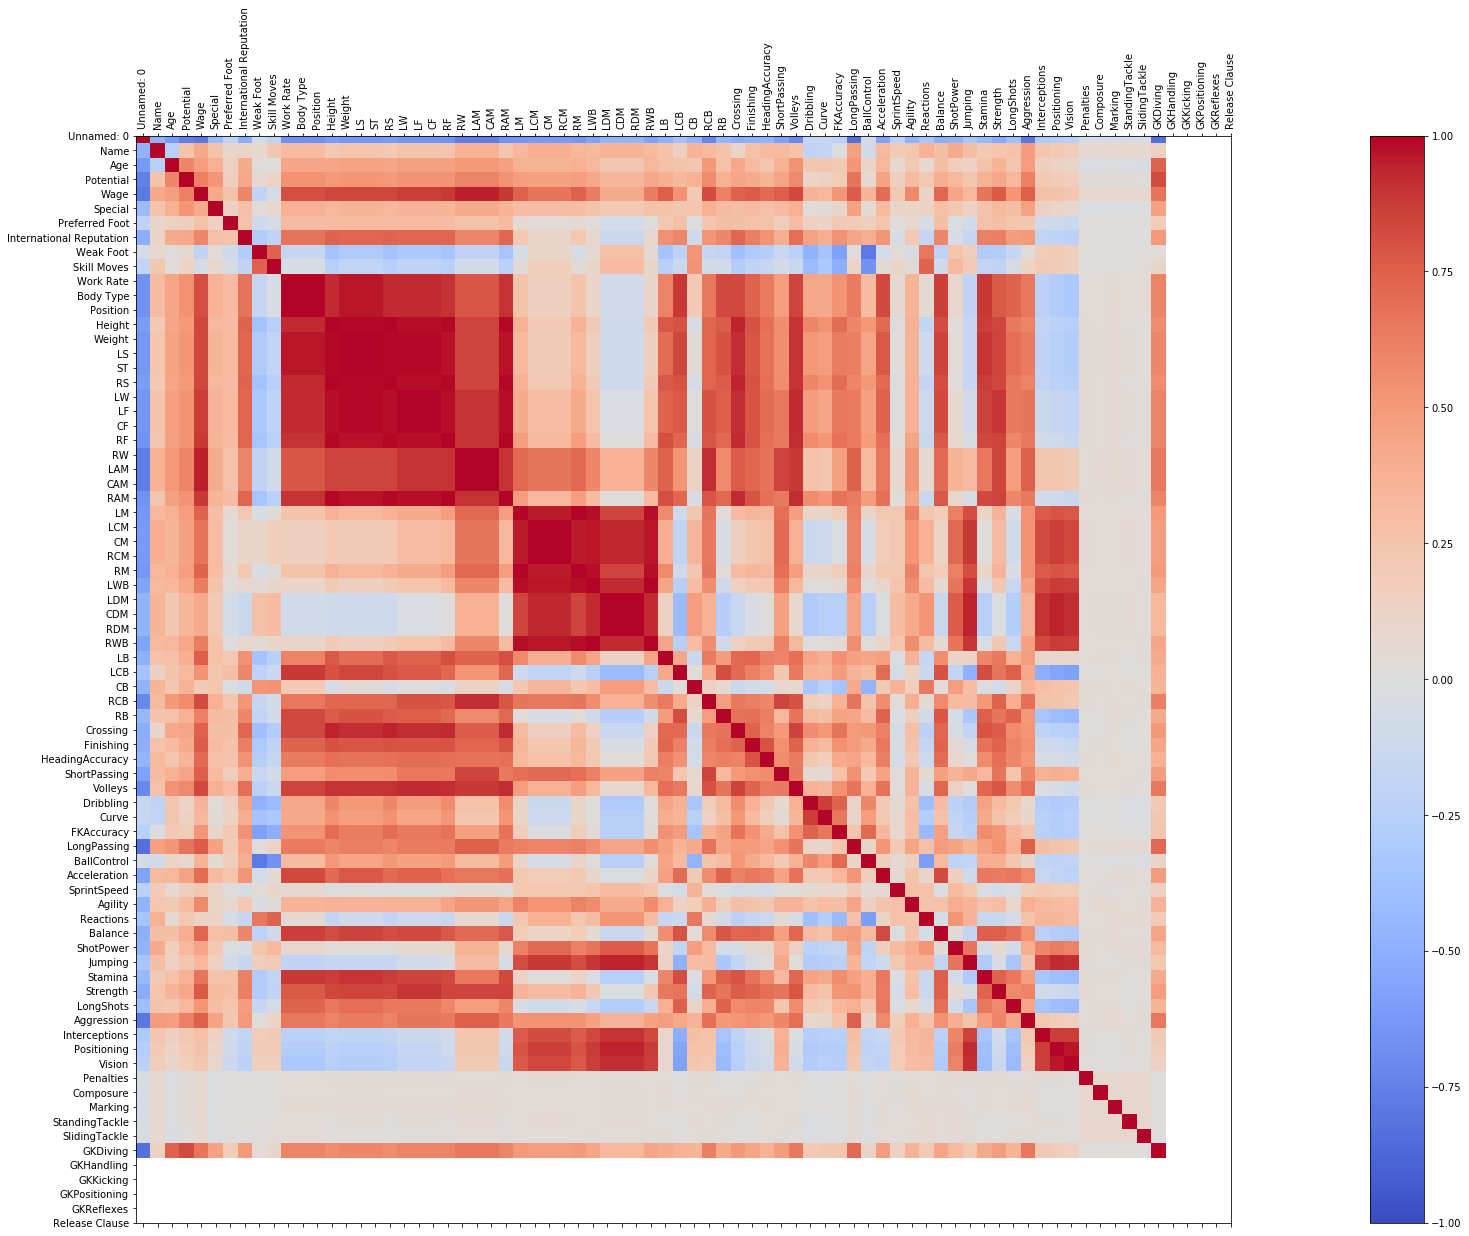

In [37]:
#Now that null values are taken care of I'll look into correlation between
#variables to determine which variables are less important
corr = X.corr()
fig = plt.figure(figsize=(50,20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns)
ax.set_yticklabels(X.columns)
plt.show()

In [38]:
#removing any variables that are too highly correlated
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)
#looking at this I'll make a new heatmap with these variables to see what I'll drop

['ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'ShortPassing', 'Dribbling', 'BallControl', 'Interceptions', 'Marking', 'StandingTackle', 'SlidingTackle']


In [39]:
drop_list = ['Skill Moves', 'Weight', 'ST', 'RS', 'LW', 'LF', 
              'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 
              'CM', 'RCM', 'RM', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 
              'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'ShortPassing', 
              'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 
              'LongPassing', 'BallControl', 'SprintSpeed', 'Agility', 
              'Balance', 'ShotPower', 'Stamina', 'LongShots', 'Interceptions', 
              'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 
              'StandingTackle', 'SlidingTackle', 'Release Clause', 'value_overall']

In [40]:

print(np.abs(fifa19[drop_list].iloc[:, :].corr(
).loc[:, 'value_overall'].sort_values(ascending=True))
)
# looking at corr of variables that could be dropped

BallControl       0.530757
CM                0.530687
LCM               0.530687
RCM               0.530112
Composure         0.507280
ShortPassing      0.502599
RM                0.499370
LM                0.499370
ST                0.493437
RS                0.493437
RAM               0.487544
LAM               0.487544
CAM               0.487544
Release Clause    0.484830
RF                0.481940
CF                0.481940
LF                0.481940
LW                0.469443
RW                0.469443
RWB               0.413910
Dribbling         0.407065
ShotPower         0.397291
LongPassing       0.387083
CDM               0.375549
RDM               0.375549
LDM               0.375549
Stamina           0.370321
RB                0.358686
LB                0.358686
Vision            0.358390
Skill Moves       0.356853
LongShots         0.356417
Curve             0.341692
Crossing          0.339542
Positioning       0.321161
Volleys           0.309124
FKAccuracy        0.288548
P

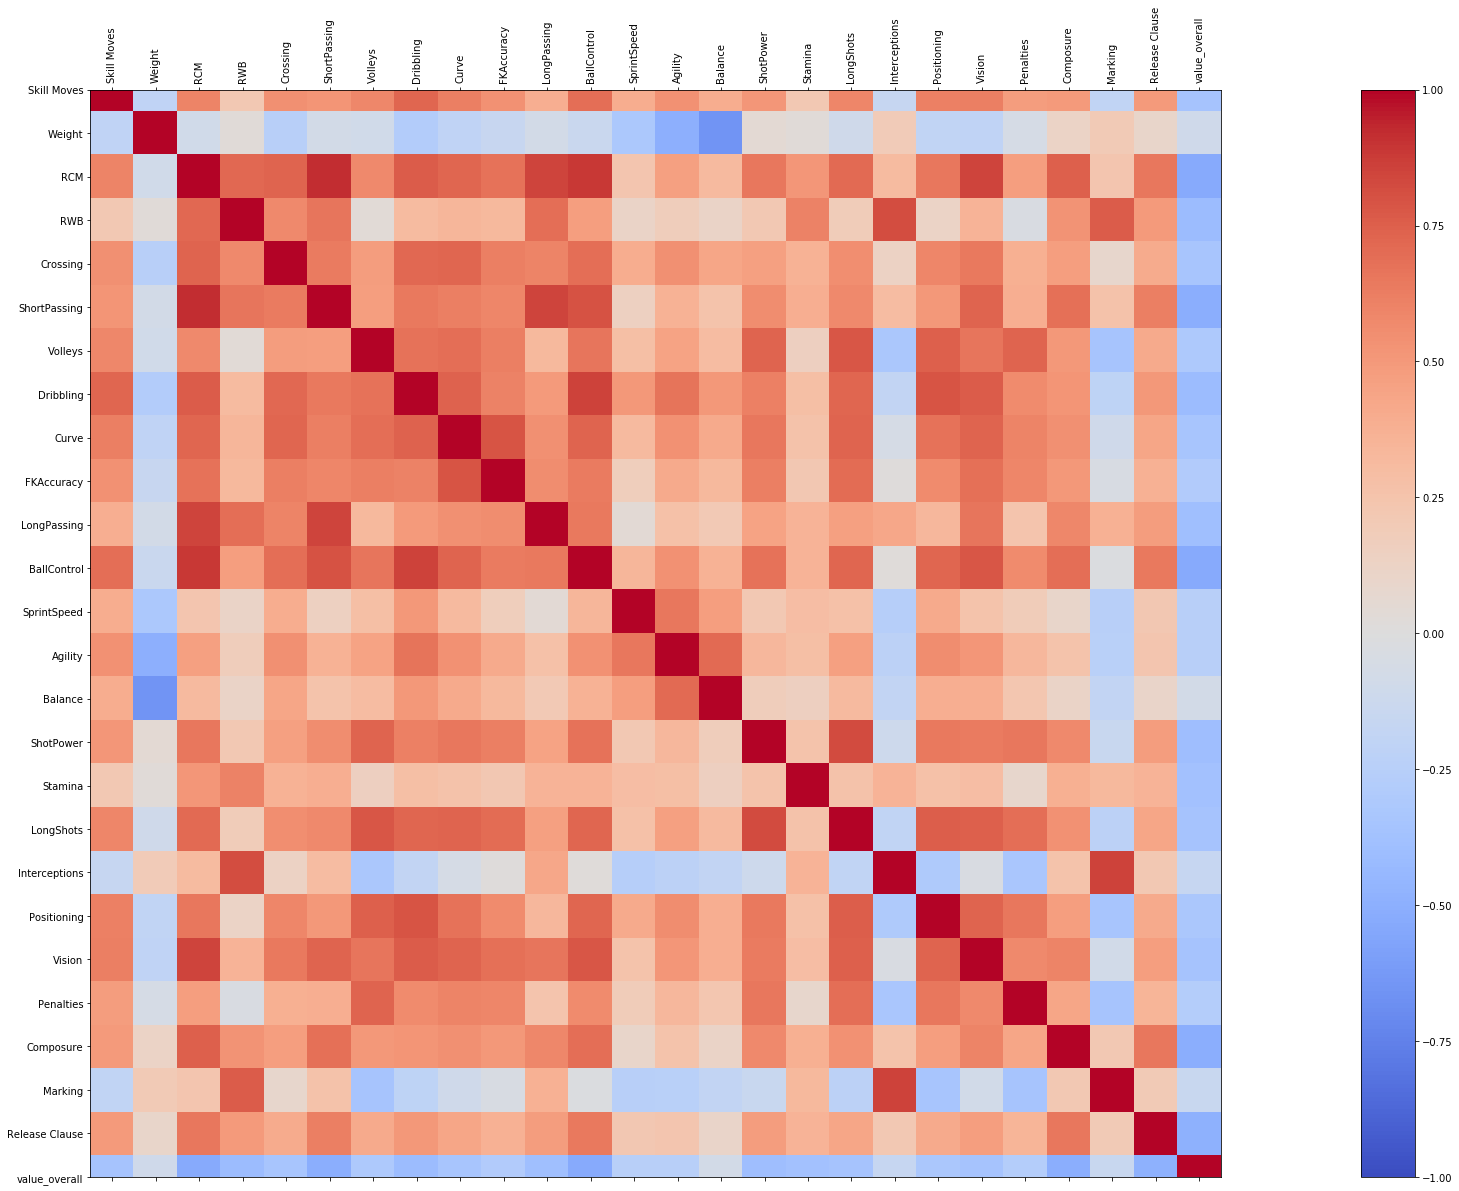

['Skill Moves', 'Weight', 'RCM', 'RWB', 'Crossing', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'SprintSpeed', 'Agility', 'Balance', 'ShotPower', 'Stamina', 'LongShots', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'Release Clause', 'value_overall']


In [43]:
corr = fifa19[drop_list].corr()
fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(fifa19[drop_list].columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(fifa19[drop_list].columns)
ax.set_yticklabels(fifa19[drop_list].columns)
plt.show()
drop = ['ST', 'RS', 'LW', 'LF', 'CF', 'RF',
        'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
        'CM', 'RM', 'LDM', 'CDM', 'RDM', 'LB',
        'LCB', 'CB', 'RCB', 'RB', 'StandingTackle', 'SlidingTackle']
drop_list = [ele for ele in drop_list if ele not in drop]
print(drop_list)

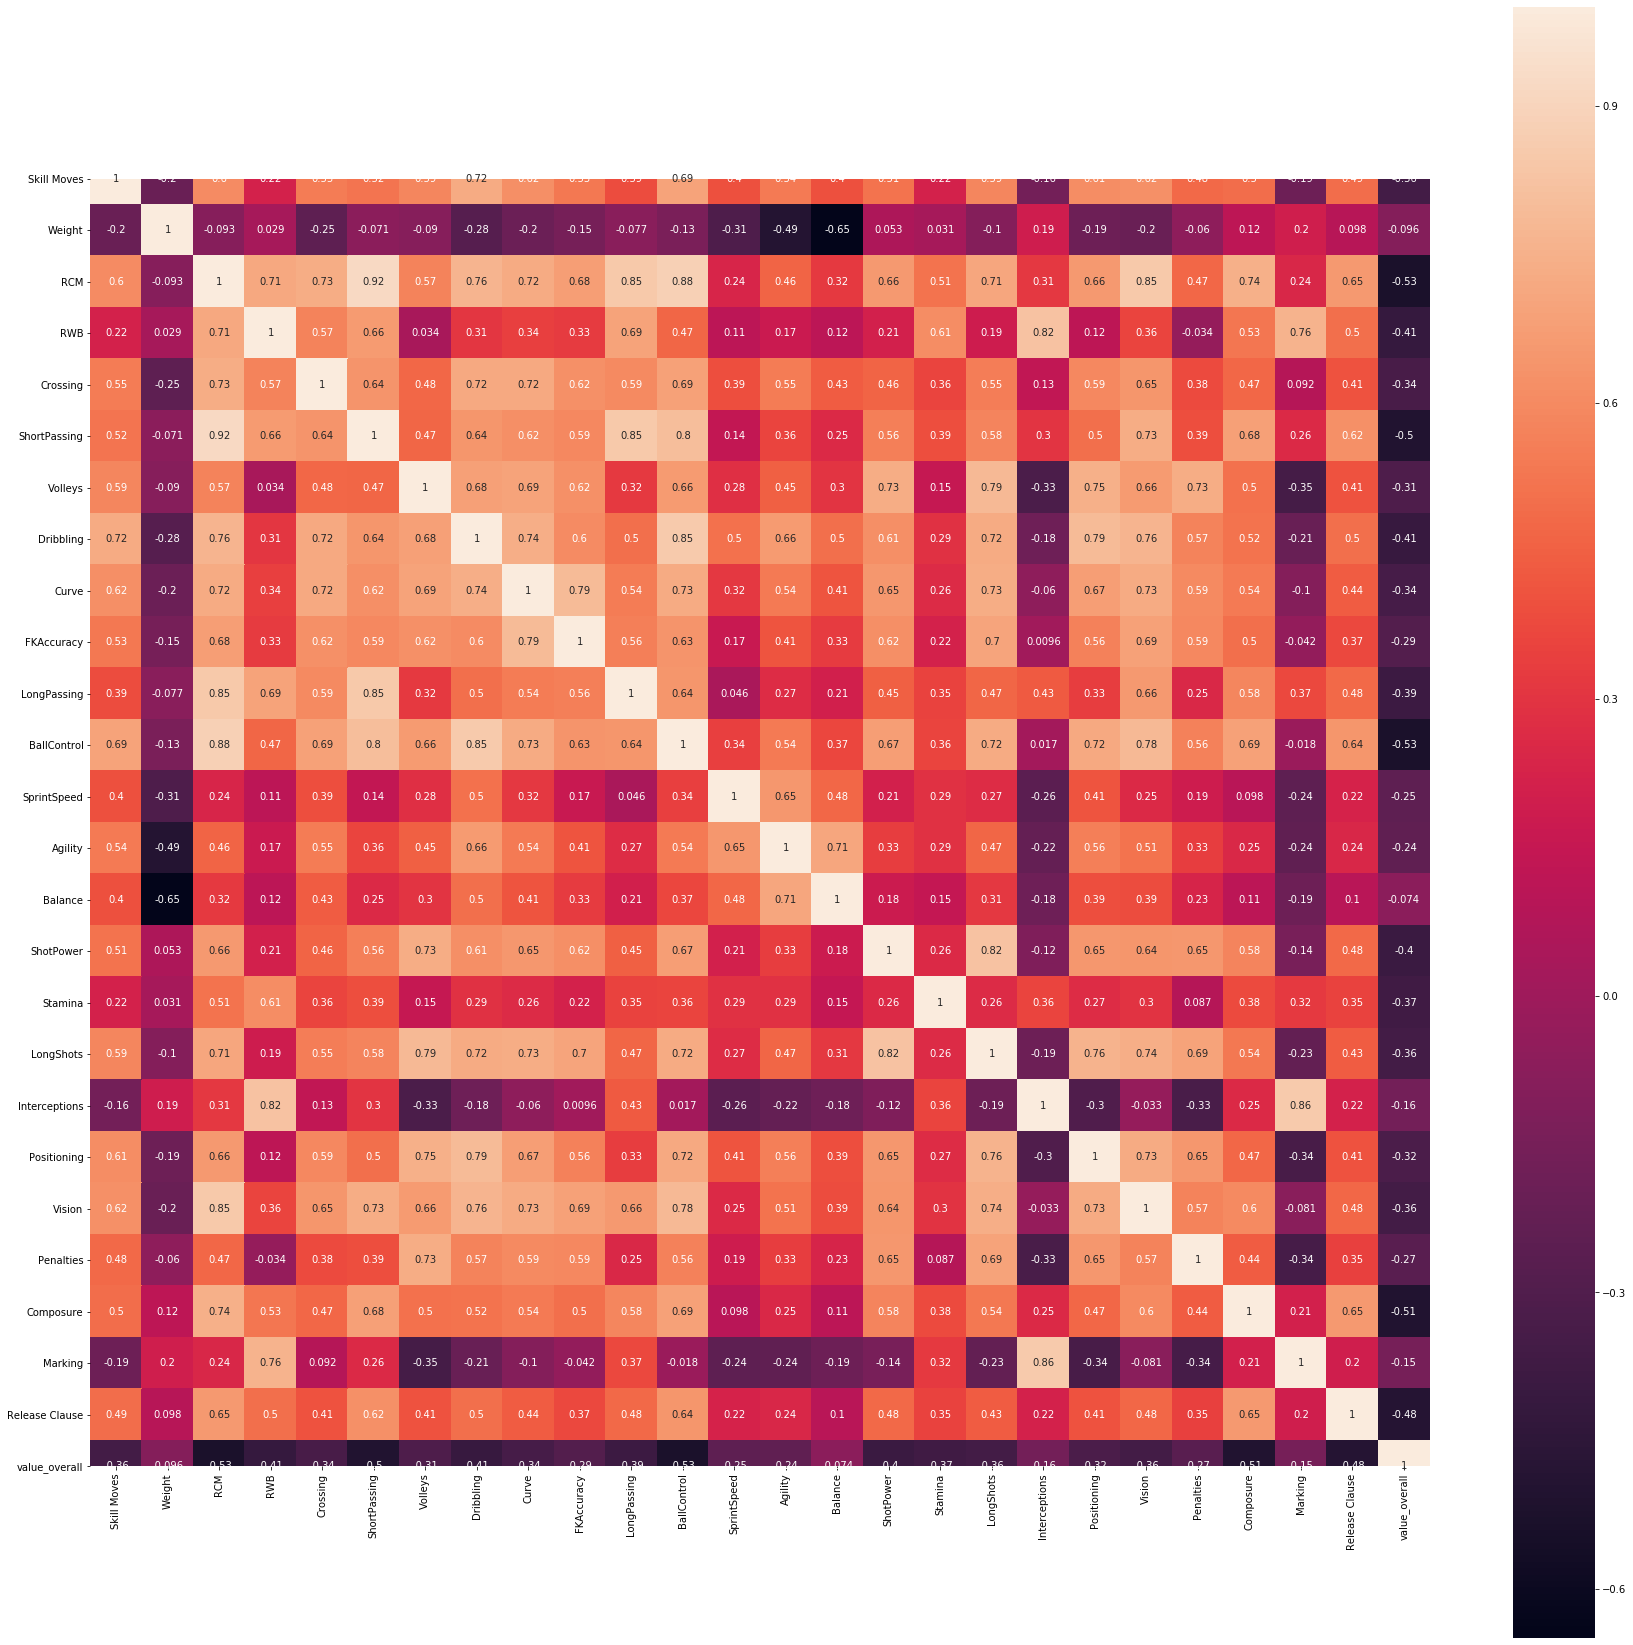

In [44]:
plt.figure(figsize=(30,30))
sns.heatmap(corr, square=True, annot=True)

In [45]:
## I've dropped all the columns with over 90% correlation to each other. 

In [46]:
#X and y assignments
X = fifa19.loc[:, fifa19.columns != 'Value']
X = X.drop(columns='Overall')
X = X.drop(columns='value_overall')
X = X.drop(columns=drop)
y = fifa19['value_overall']
print(X.columns)

Index(['Unnamed: 0', 'Name', 'Age', 'Potential', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Position', 'Height', 'Weight',
       'LS', 'RCM', 'LWB', 'RWB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause'],
      dtype='object')


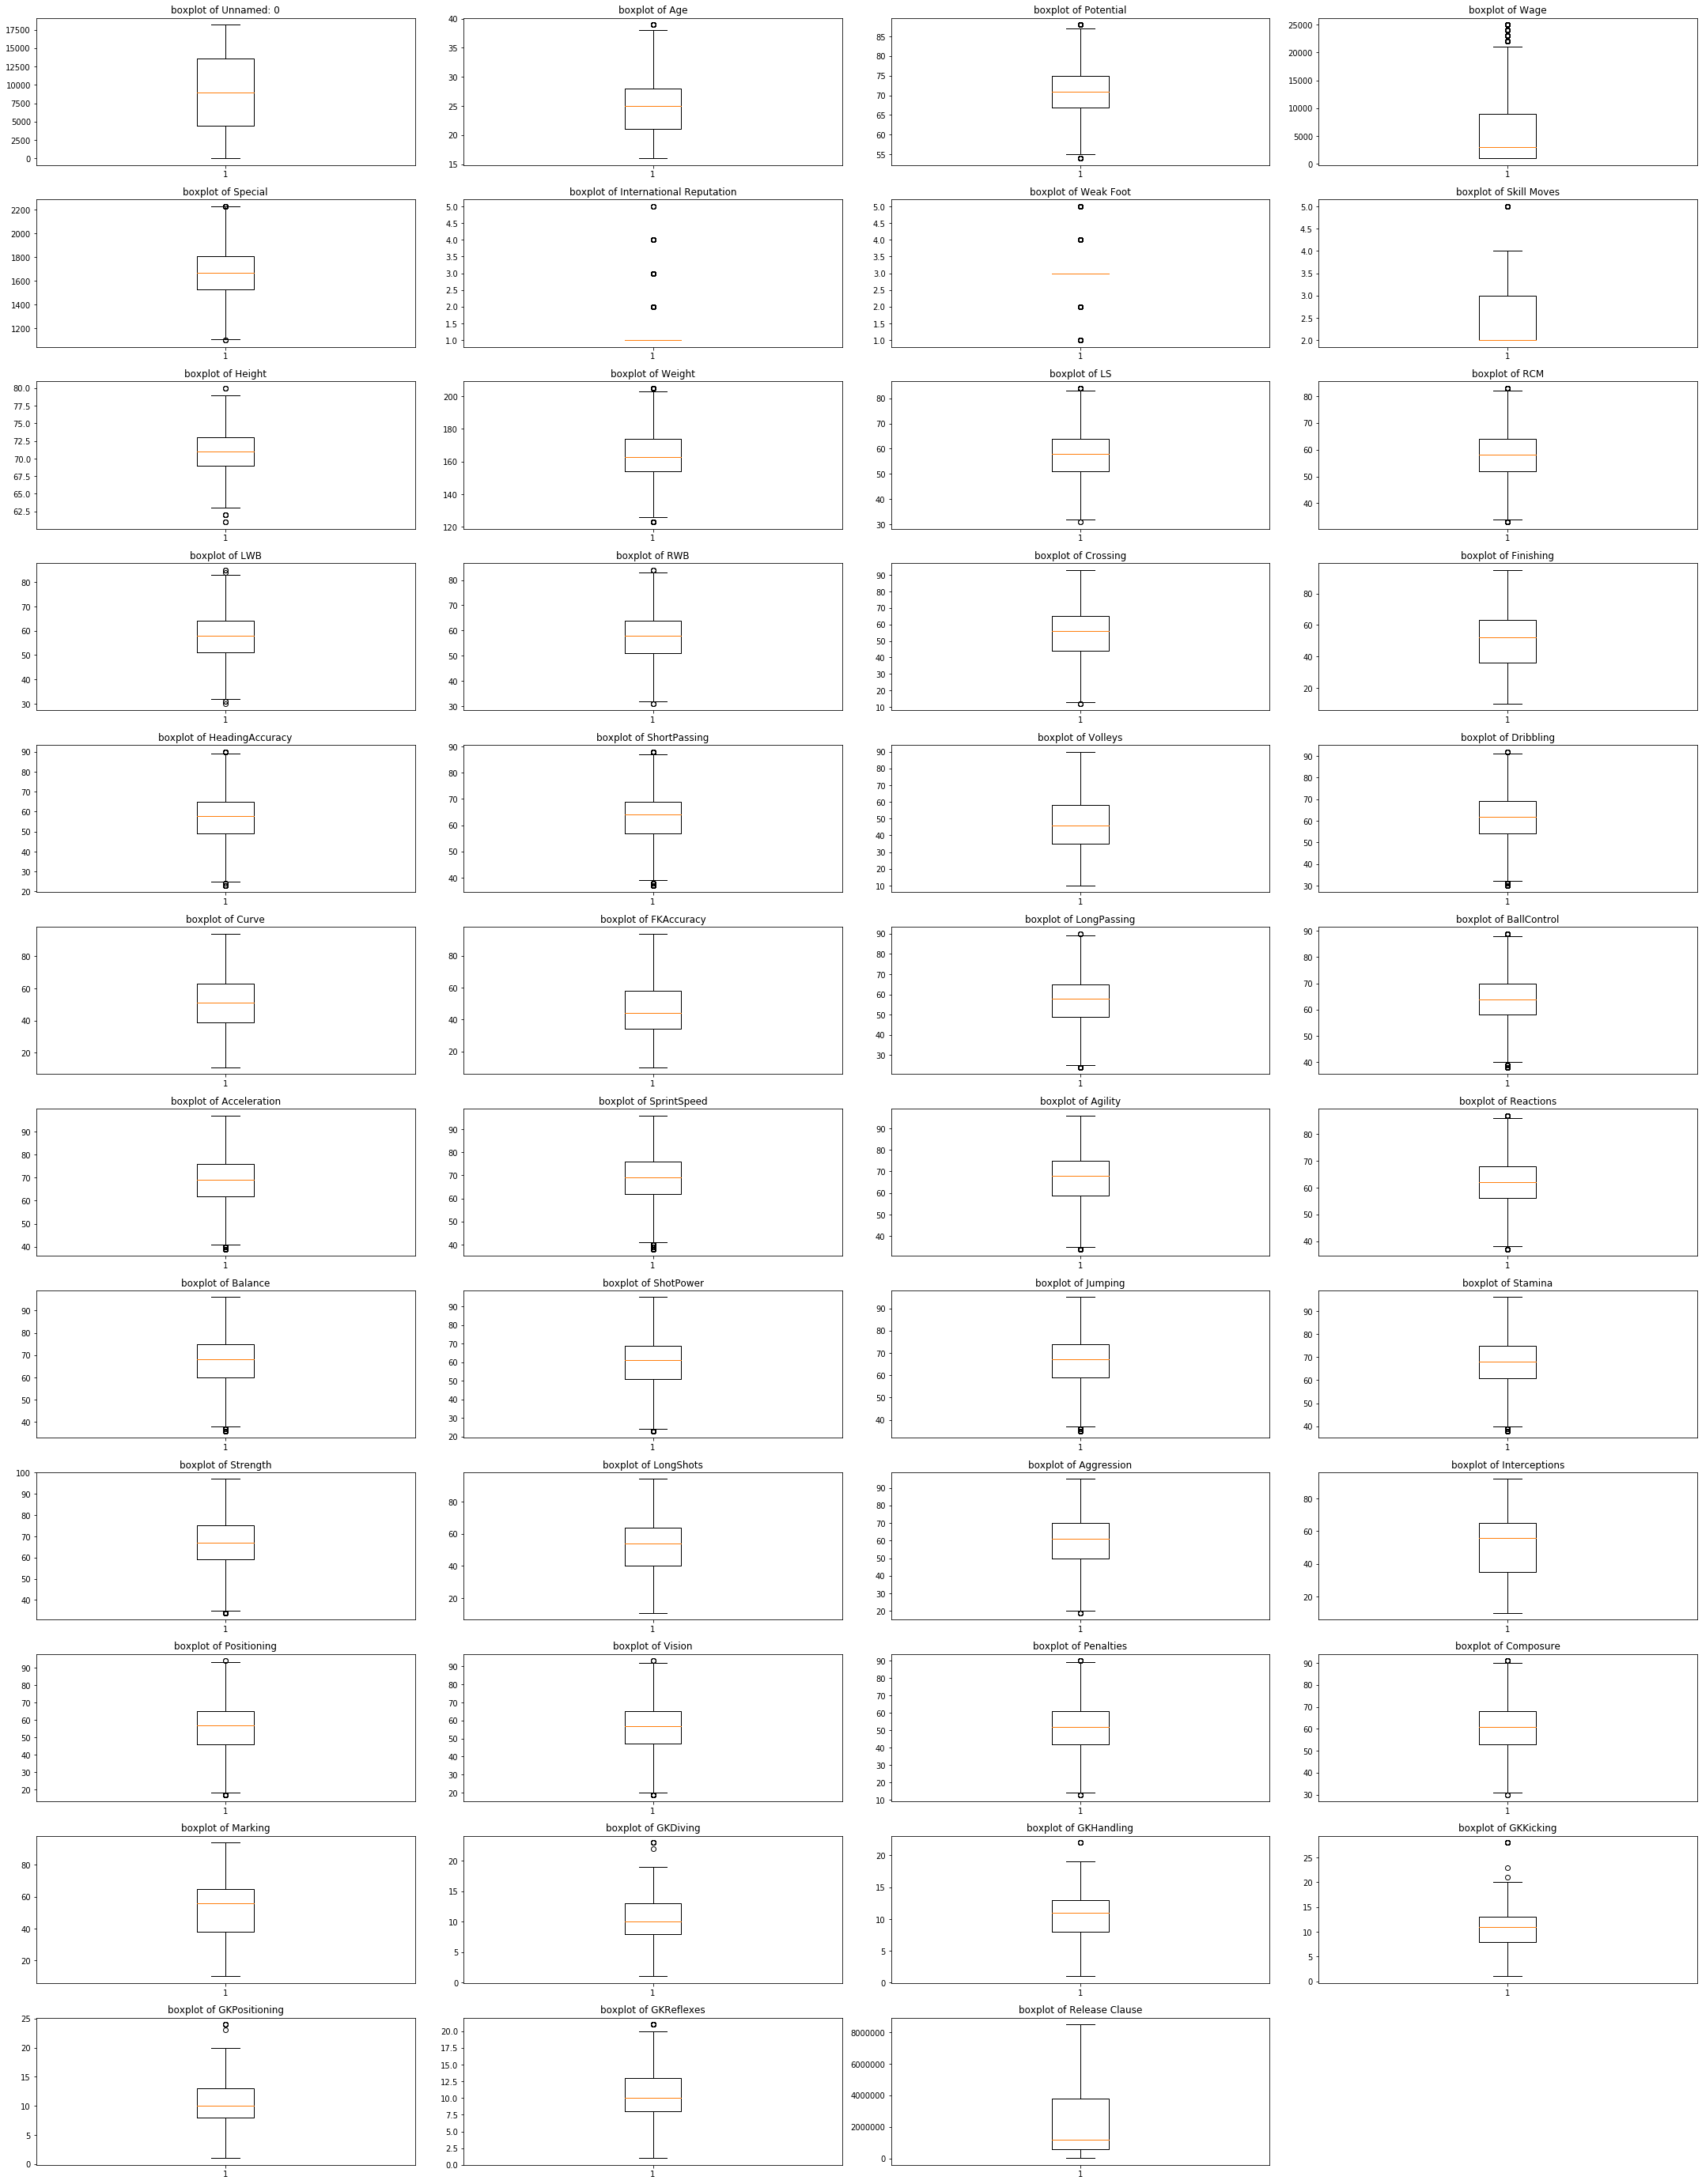

In [47]:
X_cont = X.select_dtypes(exclude='object')
fig = plt.figure(figsize=(30,150))
for i, col in enumerate(X_cont.columns):
    
    plt.subplot(len(X_cont.columns), 4, i+1)
    plt.boxplot(X[col])
    plt.title('boxplot of {}'.format(col))
    plt.tight_layout()


In [48]:
#Looks like I left Name and Unnamed: 0 in there. I'll drop that now
X = X.drop(columns=['Name', 'Unnamed: 0'])

print(list(X.columns))

['Age', 'Potential', 'Wage', 'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Position', 'Height', 'Weight', 'LS', 'RCM', 'LWB', 'RWB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause']


## getting dummies for X

In [49]:
# Get dummies for X
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)
# X head
X.head()

,Age,Potential,Wage,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,...,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST
0,31,88,25000.0,2202,5.0,4.0,4.0,67.0,159.0,84.0,...,0,0,0,0,1,0,0,0,0,0
1,33,88,25000.0,2228,5.0,4.0,5.0,74.0,183.0,84.0,...,0,0,0,0,0,0,0,0,0,1
2,26,88,25000.0,2143,5.0,5.0,5.0,69.0,150.0,84.0,...,0,0,0,0,0,0,0,0,0,0
4,27,88,25000.0,2230,4.0,5.0,4.0,71.0,154.0,82.0,...,0,0,1,0,0,0,0,0,0,0
5,27,88,25000.0,2142,4.0,4.0,4.0,68.0,163.0,83.0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
print(X_train.shape)
print(X_test.shape)


#X = scaler.fit_transform(X)
y = fifa19['value_overall']

(11057, 88)
(3686, 88)


The number of observations in training set is 11057
The number of observations in test set is 3686


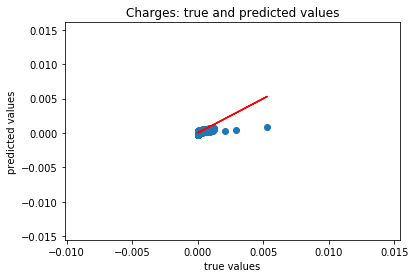

Mean absolute error of the prediction is: 7.113651345438076e-05
Mean squared error of the prediction is: 1.8344643855391447e-08
Root mean squared error of the prediction is: 0.0001354424005080811
Mean absolute percentage error of the prediction is: 244.05013746241687


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          value_overall   R-squared (uncentered):                   0.695
Model:                            OLS   Adj. R-squared (uncentered):              0.694
Method:                 Least Squares   F-statistic:                              380.1
Date:                Mon, 30 Dec 2019   Prob (F-statistic):                        0.00
Time:                        12:39:38   Log-Likelihood:                      1.0994e+05
No. Observations:               14743   AIC:                                 -2.197e+05
Df Residuals:                   14655   BIC:                                 -2.190e+05
Df Model:                          88                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Age                            1.241e-06   5.04e-07      2.465      0.014    2.54e-07    2.23e-06
Potential                     -1.349e-05   4.07e-07    -33.161      0.000   -1.43e-05   -1.27e-05
Wage                           8.884e-10   2.83e-10      3.143      0.002    3.34e-10    1.44e-09
Special                        3.742e-07   2.98e-07      1.256      0.209    -2.1e-07    9.58e-07
International Reputation       7.567e-05   3.62e-06     20.901      0.000    6.86e-05    8.28e-05
Weak Foot                      8.631e-07   1.96e-06      0.441      0.659   -2.97e-06     4.7e-06
Skill Moves                    5.419e-07   3.05e-06      0.178      0.859   -5.44e-06    6.52e-06
Height                         5.333e-06   8.67e-07      6.153      0.000    3.63e-06    7.03e-06
Weight                        -2.979e-07   1.42e-07     -2.101      0.036   -5.76e-07      -2e-08
LS                            -3.157e-05   3.62e-06     -8.717      0.000   -3.87e-05   -2.45e-05
RCM                           -1.657e-05   3.24e-06     -5.123      0.000   -2.29e-05   -1.02e-05
LWB                            7.389e-05   8.13e-05      0.909      0.363   -8.55e-05       0.000
RWB                           -7.809e-05   8.14e-05     -0.960      0.337      -0.000    8.14e-05
Crossing                      -1.819e-07   2.34e-07     -0.779      0.436    -6.4e-07    2.76e-07
Finishing                      5.264e-06   7.08e-07      7.433      0.000    3.88e-06    6.65e-06
HeadingAccuracy                1.185e-06   4.84e-07      2.449      0.014    2.37e-07    2.13e-06
ShortPassing                   1.564e-06   6.07e-07      2.578      0.010    3.75e-07    2.75e-06
Volleys                        3.464e-07   3.43e-07      1.010      0.313   -3.26e-07    1.02e-06
Dribbling                      2.849e-06   4.23e-07      6.727      0.000    2.02e-06    3.68e-06
Curve                         -3.943e-07   3.38e-07     -1.165      0.244   -1.06e-06    2.69e-07
FKAccuracy                    -4.191e-07   3.32e-07     -1.263      0.207   -1.07e-06    2.31e-07
LongPassing                    1.952e-06   5.06e-07      3.858      0.000     9.6e-07    2.94e-06
BallControl                    1.225e-06   6.08e-07      2.015      0.044    3.34e-08    2.42e-06
Acceleration                   3.243e-07   3.41e-07      0.950      0.342   -3.45e-07    9.93e-07
SprintSpeed                    2.232e-08    3.3e-07      0.068      0.946   -6.24e-07    6.68e-07
Agility                       -1.122e-06   3.51e-07     -3.195      0.001   -1.81e-06   -4.34e-07
Reactions                     -2.982e-07   4.21e-07     -0.709      0.478   -1.12e-06    5.26e-07
Balance                        1.019e-06   3

In [51]:
y = fifa19['value_overall']
#starting with OLS
results = sm.OLS(y, X).fit()



print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)


# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

display(results.summary())


## That model is not great with an adjusted R-squared value of 0.694. I'll log transform my y variable and try again

## I am interested in knowing the time to run these algorithms as well as the performance so I'll use a log time function

In [52]:
# function 
import atexit
from time import time, strftime, localtime
from datetime import timedelta

def secondsToStr(elapsed=None):
    if elapsed is None:
        return strftime("%Y-%m-%d %H:%M:%S", localtime())
    else:
        return str(timedelta(seconds=elapsed))

def log(s, elapsed=None):
    line = "="*40
    print(line)
    print(secondsToStr(), '-', s)
    if elapsed:
        print("Elapsed time:", elapsed)
    print(line)
    print()

def endlog():
    end = time()
    elapsed = end-start
    log("End Program", secondsToStr(elapsed))

## Log transform y to hopefully get some better results

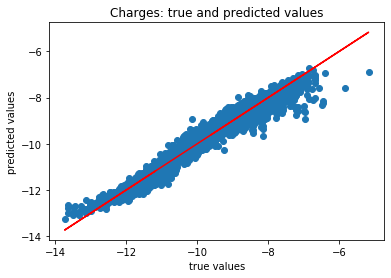

Mean absolute error of the prediction is: 0.22191398859615388
Mean squared error of the prediction is: 0.08776963022465166
Root mean squared error of the prediction is: 0.29625939685460045
Mean absolute percentage error of the prediction is: 2.433899478518335


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     2997.
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:52:05   Log-Likelihood:                -2947.6
No. Observations:               14743   AIC:                             6073.
Df Residuals:                   14654   BIC:                             6749.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.5621      0.339      1.656      0.098      -0.103       1.227
Age                               0.0053      0.001      4.884      0.000       0.003       0.007
Potential                        -0.0498      0.001    -56.849      0.000      -0.051      -0.048
Wage                          -3.897e-06   5.98e-07     -6.512      0.000   -5.07e-06   -2.72e-06
Special                          -0.0003      0.001     -0.545      0.586      -0.002       0.001
International Reputation         -0.0140      0.008     -1.825      0.068      -0.029       0.001
Weak Foot                        -0.0034      0.004     -0.822      0.411      -0.012       0.005
Skill Moves                      -0.0736      0.006    -11.392      0.000      -0.086      -0.061
Height                            0.0010      0.002      0.523      0.601      -0.003       0.005
Weight                           -0.0013      0.000     -4.316      0.000      -0.002      -0.001
LS                               -0.0110      0.008     -1.436      0.151      -0.026       0.004
RCM                              -0.0046      0.007     -0.666      0.505      -0.018       0.009
LWB                              -0.1465      0.172     -0.851      0.395      -0.484       0.191
RWB                               0.1518      0.172      0.882      0.378      -0.186       0.489
Crossing                       -1.81e-05      0.000     -0.037      0.971      -0.001       0.001
Finishing                         0.0004      0.001      0.242      0.809      -0.003       0.003
HeadingAccuracy                  -0.0034      0.001     -3.358      0.001      -0.005      -0.001
ShortPassing                     -0.0107      0.001     -8.368      0.000      -0.013      -0.008
Volleys                           0.0011      0.001      1.556      0.120      -0.000       0.003
Dribbling                         0.0009      0.001      0.970      0.332      -0.001       0.003
Curve                             0.0011      0.001      1.539      0.124      -0.000       0.003
FKAccuracy                       -0.0010      0.001     -1.460      0.144      -0.002       0.000
LongPassing                       0.0015      0.001      1.438      0.150      -0.001       0.004
BallControl                      -0.0132      0.001    -10.273      0.000      -0.016      -0.011
Acceleration                     -0.0031      0.001     -4.305      0.000      -0.005      -0.002
SprintSpeed                      -0.0041      0.001     -5.846      0.000      -0.005      -0.003
Agility                          -0.0014      0.001     -1.856      0.063      -0.003    7.74e-05
Reactions                        -0.0165      0.001    -18.535      0.000      -0.018      -0.015
Balance                           0.0019     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          value_overall   R-squared (uncentered):                   0.693
Model:                            OLS   Adj. R-squared (uncentered):              0.691
Method:                 Least Squares   F-statistic:                              285.0
Date:                Mon, 30 Dec 2019   Prob (F-statistic):                        0.00
Time:                        12:52:05   Log-Likelihood:                          82363.
No. Observations:               11057   AIC:                                 -1.646e+05
Df Residuals:                   10970   BIC:                                 -1.639e+05
Df Model:                          87                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Age                            1.741e-06   5.86e-07      2.970      0.003    5.92e-07    2.89e-06
Potential                     -1.297e-05   4.72e-07    -27.476      0.000   -1.39e-05    -1.2e-05
Wage                           9.247e-10   3.29e-10      2.809      0.005    2.79e-10    1.57e-09
Special                       -9.468e-07    3.5e-07     -2.703      0.007   -1.63e-06    -2.6e-07
International Reputation       7.341e-05   4.21e-06     17.417      0.000    6.51e-05    8.17e-05
Weak Foot                      1.363e-06   2.29e-06      0.596      0.551   -3.12e-06    5.84e-06
Skill Moves                    1.569e-06   3.56e-06      0.441      0.659    -5.4e-06    8.54e-06
Height                         6.352e-06   9.94e-07      6.393      0.000     4.4e-06     8.3e-06
Weight                        -2.453e-07   1.65e-07     -1.482      0.138    -5.7e-07    7.91e-08
LS                            -2.493e-05   4.22e-06     -5.900      0.000   -3.32e-05   -1.66e-05
RCM                           -1.286e-05   3.78e-06     -3.400      0.001   -2.03e-05   -5.45e-06
LWB                            6.764e-05   8.22e-05      0.823      0.411   -9.35e-05       0.000
RWB                           -5.976e-05   8.23e-05     -0.726      0.468      -0.000       0.000
Crossing                      -2.337e-07   2.72e-07     -0.858      0.391   -7.68e-07       3e-07
Finishing                      5.299e-06   8.22e-07      6.449      0.000    3.69e-06    6.91e-06
HeadingAccuracy                 1.86e-06   5.62e-07      3.311      0.001    7.59e-07    2.96e-06
ShortPassing                   8.666e-07   7.08e-07      1.224      0.221   -5.22e-07    2.25e-06
Volleys                         1.57e-06   4.01e-07      3.916      0.000    7.84e-07    2.36e-06
Dribbling                      2.856e-06   4.92e-07      5.810      0.000    1.89e-06    3.82e-06
Curve                          8.823e-07   3.97e-07      2.225      0.026    1.05e-07    1.66e-06
FKAccuracy                     9.498e-07   3.91e-07      2.430      0.015    1.84e-07    1.72e-06
LongPassing                    2.572e-06    5.9e-07      4.360      0.000    1.42e-06    3.73e-06
BallControl                    2.275e-07   7.08e-07      0.321      0.748   -1.16e-06    1.62e-06
Acceleration                   1.015e-06   3.98e-07      2.553      0.011    2.36e-07    1.79e-06
SprintSpeed                    1.597e-07   3.85e-07      0.414      0.679   -5.96e-07    9.15e-07
Agility                        2.629e-07   4.11e-07      0.639      0.523   -5.44e-07    1.07e-06
Reactions                     -1.217e-06   4.91e-07     -2.481      0.013   -2.18e-06   -2.56e-07
Balance                        2.548e-06   4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     54.79
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:52:05   Log-Likelihood:                 27650.
No. Observations:                3686   AIC:                        -5.513e+04
Df Residuals:                    3603   BIC:                        -5.462e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Age                           -9.931e-07   9.94e-07     -1.000      0.318   -2.94e-06    9.55e-07
Potential                     -1.546e-05   8.08e-07    -19.150      0.000    -1.7e-05   -1.39e-05
Wage                           7.709e-10   5.55e-10      1.390      0.165   -3.16e-10    1.86e-09
Special                        4.019e-06   5.71e-07      7.042      0.000     2.9e-06    5.14e-06
International Reputation       8.107e-05   7.12e-06     11.390      0.000    6.71e-05     9.5e-05
Weak Foot                     -1.423e-07   3.79e-06     -0.038      0.970   -7.57e-06    7.29e-06
Skill Moves                   -2.736e-06   5.95e-06     -0.460      0.646   -1.44e-05    8.93e-06
Height                         6.578e-07   1.82e-06      0.362      0.717    -2.9e-06    4.22e-06
Weight                         -4.04e-07   2.76e-07     -1.465      0.143   -9.45e-07    1.37e-07
LS                            -4.788e-05   7.08e-06     -6.760      0.000   -6.18e-05    -3.4e-05
RCM                            -2.48e-05   6.26e-06     -3.961      0.000   -3.71e-05   -1.25e-05
LWB                           -1.884e-05    2.9e-06     -6.493      0.000   -2.45e-05   -1.32e-05
RWB                           -1.884e-05    2.9e-06     -6.493      0.000   -2.45e-05   -1.32e-05
Crossing                      -3.582e-09   4.55e-07     -0.008      0.994   -8.97e-07    8.89e-07
Finishing                       4.75e-06   1.41e-06      3.379      0.001    1.99e-06    7.51e-06
HeadingAccuracy                -8.52e-07   9.59e-07     -0.888      0.374   -2.73e-06    1.03e-06
ShortPassing                   2.753e-06   1.18e-06      2.331      0.020    4.38e-07    5.07e-06
Volleys                        -3.02e-06   6.68e-07     -4.519      0.000   -4.33e-06   -1.71e-06
Dribbling                      2.572e-06   8.36e-07      3.076      0.002    9.33e-07    4.21e-06
Curve                         -3.977e-06   6.56e-07     -6.067      0.000   -5.26e-06   -2.69e-06
FKAccuracy                    -4.142e-06   6.33e-07     -6.545      0.000   -5.38e-06    -2.9e-06
LongPassing                    1.668e-07   9.89e-07      0.169      0.866   -1.77e-06    2.11e-06
BallControl                    3.454e-06   1.19e-06      2.904      0.004    1.12e-06    5.79e-06
Acceleration                   -1.77e-06   6.68e-07     -2.651      0.008   -3.08e-06   -4.61e-07
SprintSpeed                   -4.456e-07   6.39e-07     -0.697      0.486    -1.7e-06    8.07e-07
Agility                       -4.936e-06   6.79e-07     -7.271      0.000   -6.27e-06   -3.61e-06
Reactions                      2.044e-06   8.18e-07      2.499      0.012     4.4e-07    3.65e-06
Balance                       -3.337e-06   6.74e-07     -4.953      0.000   -4.66e-06   -2.02e-06
ShotPower                      6.788e-08   9.

2019-12-30 12:52:05 - OLS
Elapsed time: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c1e293c50>

2019-12-30 12:52:05 - End Program
Elapsed time: 0:00:00.098849



In [53]:
# y variable is now log transformed
y = np.log(fifa19.value_overall)
results = sm.OLS(y, X).fit()
results_train = sm.OLS(y_train, X_train).fit()
results_test = sm.OLS(y_test, X_test).fit()

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

display(results.summary())
display(results_train.summary())
display(results_test.summary())

#checking time to run model
start = time()
atexit.register(endlog)
log('OLS', sm.OLS(y,X).fit())
endlog()


## some variables have very high p values. I am going to start with dropping all p values over .100. Run time is almost 1/10th of a second. But with and adjusted r-squared score of .947 I think that this model is performing quite well.

In [54]:
high_pval = ['Special', 'Weak Foot', 'Height', 'LS', 'RCM', 'LWB', 'RWB',
             'RWB', 'Crossing', 'Finishing', 'Volleys', 'Dribbling',
             'Curve', 'FKAccuracy', 'LongPassing', 'ShotPower', 'Jumping',
             'LongShots', 'Aggression', 'Penalties', 'GKHandling', 'GKKicking',
             'GKPositioning', 'Position_LAM', 'Position_LM', 'Position_LW',
             'Position_RF', 'Position_RM', 'Position_RS', 'Position_RW',
             'Position_ST']

In [55]:
X = X.drop(columns=high_pval)

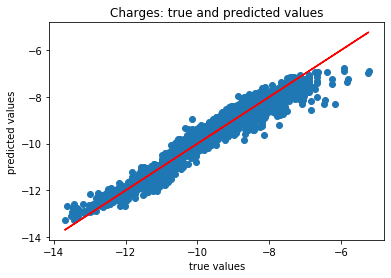

Mean absolute error of the prediction is: 0.22863463571886464
Mean squared error of the prediction is: 0.09352654406605526
Root mean squared error of the prediction is: 0.30582109813754715
Mean absolute percentage error of the prediction is: 2.51509697979638


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     4527.
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        13:11:26   Log-Likelihood:                -2992.2
No. Observations:               14743   AIC:                             6102.
Df Residuals:                   14684   BIC:                             6551.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.6825      0.317      2.151      0.031       0.061       1.304
Age                               0.0043      0.001      4.111      0.000       0.002       0.006
Potential                        -0.0502      0.001    -57.770      0.000      -0.052      -0.048
Wage                           -3.81e-06   5.97e-07     -6.379      0.000   -4.98e-06   -2.64e-06
International Reputation         -0.0123      0.008     -1.621      0.105      -0.027       0.003
Skill Moves                      -0.0758      0.006    -12.138      0.000      -0.088      -0.064
Weight                           -0.0013      0.000     -4.885      0.000      -0.002      -0.001
HeadingAccuracy                  -0.0050      0.000    -15.000      0.000      -0.006      -0.004
ShortPassing                     -0.0115      0.001    -20.803      0.000      -0.013      -0.010
BallControl                      -0.0156      0.001    -24.504      0.000      -0.017      -0.014
Acceleration                     -0.0036      0.001     -6.989      0.000      -0.005      -0.003
SprintSpeed                      -0.0047      0.000    -10.074      0.000      -0.006      -0.004
Agility                          -0.0017      0.000     -4.495      0.000      -0.002      -0.001
Reactions                        -0.0177      0.001    -32.137      0.000      -0.019      -0.017
Balance                           0.0015      0.000      4.049      0.000       0.001       0.002
Stamina                          -0.0079      0.000    -25.687      0.000      -0.008      -0.007
Strength                         -0.0050      0.000    -13.478      0.000      -0.006      -0.004
Interceptions                    -0.0011      0.000     -3.472      0.001      -0.002      -0.000
Positioning                      -0.0007      0.000     -1.977      0.048      -0.001    -6.1e-06
Vision                            0.0023      0.000      5.737      0.000       0.002       0.003
Composure                        -0.0049      0.000    -10.900      0.000      -0.006      -0.004
Marking                          -0.0022      0.000     -7.177      0.000      -0.003      -0.002
GKDiving                         -0.0029      0.001     -3.684      0.000      -0.005      -0.001
GKReflexes                       -0.0026      0.001     -3.235      0.001      -0.004      -0.001
Release Clause                -1.718e-07   1.97e-09    -87.121      0.000   -1.76e-07   -1.68e-07
Preferred Foot_Right              0.0188      0.007      2.845      0.004       0.006       0.032
Work Rate_High/ Low              -0.0906      0.016     -5.636      0.000      -0.122      -0.059
Work Rate_High/ Medium           -0.0375      0.012     -3.252      0.001      -0.060      -0.015
Work Rate_Low/ High              -0.0681     

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     3525.
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        13:11:26   Log-Likelihood:                -2116.6
No. Observations:               11057   AIC:                             4349.
Df Residuals:                   10999   BIC:                             4773.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.4401      0.114     -3.854      0.000      -0.664      -0.216
Age                               0.0031      0.001      2.635      0.008       0.001       0.005
Potential                        -0.0504      0.001    -50.775      0.000      -0.052      -0.048
Wage                          -4.118e-06   6.79e-07     -6.062      0.000   -5.45e-06   -2.79e-06
International Reputation         -0.0125      0.009     -1.408      0.159      -0.030       0.005
Skill Moves                      -0.0732      0.007    -10.257      0.000      -0.087      -0.059
Weight                           -0.0014      0.000     -4.406      0.000      -0.002      -0.001
HeadingAccuracy                  -0.0051      0.000    -13.493      0.000      -0.006      -0.004
ShortPassing                     -0.0110      0.001    -17.457      0.000      -0.012      -0.010
BallControl                      -0.0157      0.001    -21.375      0.000      -0.017      -0.014
Acceleration                     -0.0041      0.001     -6.923      0.000      -0.005      -0.003
SprintSpeed                      -0.0045      0.001     -8.342      0.000      -0.006      -0.003
Agility                          -0.0014      0.000     -3.142      0.002      -0.002      -0.001
Reactions                        -0.0172      0.001    -27.405      0.000      -0.018      -0.016
Balance                           0.0011      0.000      2.731      0.006       0.000       0.002
Stamina                          -0.0075      0.000    -21.199      0.000      -0.008      -0.007
Strength                         -0.0052      0.000    -12.346      0.000      -0.006      -0.004
Interceptions                    -0.0009      0.000     -2.594      0.009      -0.002      -0.000
Positioning                      -0.0005      0.000     -1.319      0.187      -0.001       0.000
Vision                            0.0019      0.000      4.264      0.000       0.001       0.003
Composure                        -0.0050      0.001     -9.846      0.000      -0.006      -0.004
Marking                          -0.0022      0.000     -6.306      0.000      -0.003      -0.001
GKDiving                         -0.0036      0.001     -3.902      0.000      -0.005      -0.002
GKReflexes                       -0.0028      0.001     -3.025      0.002      -0.005      -0.001
Release Clause                -1.722e-07   2.24e-09    -76.715      0.000   -1.77e-07   -1.68e-07
Preferred Foot_Right              0.0160      0.008      2.133      0.033       0.001       0.031
Work Rate_High/ Low              -0.0831      0.018     -4.506      0.000      -0.119      -0.047
Work Rate_High/ Medium           -0.0362      0.013     -2.747      0.006      -0.062      -0.010
Work Rate_Low/ High              -0.0720     

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1172.
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        13:11:26   Log-Likelihood:                -842.09
No. Observations:                3686   AIC:                             1792.
Df Residuals:                    3632   BIC:                             2128.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.4126      0.387      1.067      0.286      -0.345       1.171
Age                               0.0079      0.002      3.684      0.000       0.004       0.012
Potential                        -0.0493      0.002    -27.347      0.000      -0.053      -0.046
Wage                          -2.775e-06   1.26e-06     -2.201      0.028   -5.25e-06   -3.03e-07
International Reputation         -0.0161      0.015     -1.084      0.278      -0.045       0.013
Skill Moves                      -0.0826      0.013     -6.400      0.000      -0.108      -0.057
Weight                           -0.0012      0.001     -2.164      0.031      -0.002      -0.000
HeadingAccuracy                  -0.0047      0.001     -6.535      0.000      -0.006      -0.003
ShortPassing                     -0.0127      0.001    -11.132      0.000      -0.015      -0.010
BallControl                      -0.0159      0.001    -12.194      0.000      -0.018      -0.013
Acceleration                     -0.0022      0.001     -2.133      0.033      -0.004      -0.000
SprintSpeed                      -0.0052      0.001     -5.389      0.000      -0.007      -0.003
Agility                          -0.0028      0.001     -3.501      0.000      -0.004      -0.001
Reactions                        -0.0191      0.001    -16.744      0.000      -0.021      -0.017
Balance                           0.0024      0.001      3.293      0.001       0.001       0.004
Stamina                          -0.0093      0.001    -14.775      0.000      -0.011      -0.008
Strength                         -0.0044      0.001     -5.664      0.000      -0.006      -0.003
Interceptions                    -0.0017      0.001     -2.636      0.008      -0.003      -0.000
Positioning                      -0.0011      0.001     -1.493      0.136      -0.003       0.000
Vision                            0.0035      0.001      4.283      0.000       0.002       0.005
Composure                        -0.0045      0.001     -4.749      0.000      -0.006      -0.003
Marking                          -0.0021      0.001     -3.234      0.001      -0.003      -0.001
GKDiving                         -0.0009      0.002     -0.548      0.584      -0.004       0.002
GKReflexes                       -0.0022      0.002     -1.359      0.174      -0.005       0.001
Release Clause                -1.713e-07   4.14e-09    -41.359      0.000   -1.79e-07   -1.63e-07
Preferred Foot_Right              0.0276      0.014      2.009      0.045       0.001       0.055
Work Rate_High/ Low              -0.1176      0.033     -3.572      0.000      -0.182      -0.053
Work Rate_High/ Medium           -0.0423      0.024     -1.770      0.077      -0.089       0.005
Work Rate_Low/ High              -0.0678     

2019-12-30 13:11:26 - OLS
Elapsed time: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c21305978>

2019-12-30 13:11:26 - End Program
Elapsed time: 0:00:00.075281



In [57]:
#run train_test_split again on new X 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

y = np.log(fifa19.value_overall)
results = sm.OLS(y, X).fit()
results_train = sm.OLS(y_train, X_train).fit()
results_test = sm.OLS(y_test, X_test).fit()

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

display(results.summary())
display(results_train.summary())
display(results_test.summary())

#checking time to run model
start = time()
atexit.register(endlog)
log('OLS', sm.OLS(y,X).fit())
endlog()


## Getting rid of my statistically unimportant variables didn't affect my score and cut my run time down. Now I'll run a random forest regression and see if it performs any better

In [59]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfr = ensemble.RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
print(cross_val_score(rfr, X_train, y_train, cv=10))
print(rfr.score(X_test, y_test))

#checking time to run model
start = time()
atexit.register(endlog)
log('rfr', rfr.fit(X,y))
endlog()


[0.9912573  0.9919933  0.99144343 0.99137794 0.99137275 0.99024492
 0.99046014 0.99132026 0.99236508 0.99020039]
0.9908722257225997
2019-12-30 13:34:01 - rfr
Elapsed time: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

2019-12-30 13:34:01 - End Program
Elapsed time: 0:00:15.063513



## The random forest model is extremely accurate, and looking at cross validation, it would appear that there is no overfitting problems. At a just over 15 seconds it is significantly slower than the OLS. My next model will be the known neighbors regressor.

In [60]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=7, metric = 'minkowski', p = 2)

knn.fit(X_train, y_train)

print(knn.score(X_test,y_test))
print(cross_val_score(knn, X_train, y_train, cv=10))


#checking time to run model
start = time()
atexit.register(endlog)
log('knn', knn.fit(X,y))
endlog()


0.9785046766512695
[0.978335   0.97928721 0.97930826 0.97747533 0.97952541 0.97827004
 0.97835876 0.9790263  0.98019825 0.9787115 ]
2019-12-30 13:36:53 - knn
Elapsed time: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')

2019-12-30 13:36:53 - End Program
Elapsed time: 0:00:00.042194



## KNN is lightning fast and outperforms the OLS model with a score of almost of .98. It doesn't perform quite as good as Random Forest but the trade-off in speed makes it a better model in my opinion. 

In [61]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train,y_train).score(X,y)

print(cross_val_score(svr, X_train, y_train, cv=10))
print(svr.score(X_test, y_test))


#checking time to run model
start = time()
atexit.register(endlog)
log('svr', svr.fit(X,y))
endlog()

[-0.00857872 -0.01600912 -0.00835773 -0.01432897 -0.00379252 -0.01139539
 -0.00130363  0.00067706 -0.00641927 -0.00536719]
-0.007102583898142667
2019-12-30 13:42:45 - svr
Elapsed time: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

2019-12-30 13:42:45 - End Program
Elapsed time: 0:00:41.792200



## The scores for SVR are terrible and it took the longest to run by far. I will drop SVR as an acceptable option right off the bat.



# Conclusions:

### OLS: 
* score: 0.947
* runtime: 0.075 seconds

### Random Forest:
* score: 0.99
* runtime: 15 seconds

### KNN:
* score: 0.975
* runtime: 0.042 seconds

### SVR:
* score: -0.0071
* runtime: 42 seconds

So looking at all 4 of our options I think that OLS Random Forest and KNN are all high performing. Random Forest is the most accurate but at the cost of speed. KNN closely follows Random Forest closely in terms of accuracy, and is certainly the fastest. OLS also performs well but with KNN being both faster and better performing, I will say that OLS can be dropped. 

### Further thoughts

I am happy with the results on this, but I think given more time and data, I would like to drop all players with an overall rating under 80. The only problem I see with that is that there could be a lack of data after dropping all players under a score of 80. I would love to see if this will work as well on next year's data. 

